# E5.  Spectrogram classification 모델 구현

`19 JAN 2021`

----------

>1. 데이터 처리와 분류
>2. 학습을 위한 하이퍼파라미터 설정
>3. 데이터셋 구성
>4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
>5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
>6. Test dataset을 이용해서 모델의 성능을 평가


### *필요한 라이브러리 import

In [1]:
import numpy as np
import os


import IPython.display as ipd
import random

import librosa

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## 1. 데이터 처리와 분류

- 라벨 데이터 처리하기
   
- sklearn의 train_test_split함수를 이용하여 train, test 분리


## Wave data 분석

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


## 데이터셋 살펴보기

- npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어있습니다.

   
- 데이터셋은 캐글의 음성 인식 챌린지의 데이터입니다. 

  Kaggle/TensorFlow Speech Recognition Challenge. This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"])) #데이터를 랜덤하게 선택
print("rand num : ", rand)

sr = 8000   # 1초동안 재생되는 샘플의 갯수. sample rate.
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  35789
Wave data shape :  (8000,)
label :  ['right']


## 1차원의 Waveform 데이터 -> 2차원의 Spectrogram 데이터로 

Computes the Short-time Fourier Transform of signals.

- `librosa.stft` 

- `tf.signal.stft` tensorflow에 들어가보니 이 방법도 있었다. 



In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [6]:
# 위에서 뽑았던 data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


변환된 Spectrogram을 출력해보자~!

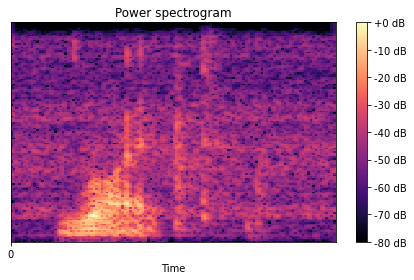

In [7]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

가져온 답변! 

spec_data=[] //빈깡통만든다음에
for wav in data: //1차원 wav 하나씩 가져오시구요.
    stft = wav2spec(wav)
    spec_data.append(stft)
spec_data = np.array(spec_data)
spec_data.shape

여기서 문제가 있었다. 내가 슬랙에 질문 올려주신 다른 분처럼 indent 의 문제?를 잘 모르고 커널이 죽는거에 대해 고민했다. 

애초에 함수를 잘못 만들었던것도 문제의 원인중에 하나였다. 
코드를 어떻게 만드느냐에 따라 진행 속도나 결과에 영향을 미친다는 것을 다시한번 생각해 볼 수 있었다. 

In [10]:
spec = []
for wav in speech_data["wav_vals"][:30000]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

In [11]:
spec.shape

(30000, 130, 126)

## Label data 처리

- 현재 단어의 정답은 Text 형태로 이뤄져있습니다. 학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.

아래는 구분해야할 label 목록입니다.

`['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]`

이외 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

In [12]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였습니다.

int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.

In [13]:
temp = []
for v in speech_data["label_vals"][:30000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([3, 3, 3, ..., 7, 7, 7])

## 학습을 위한 데이터 분리 

### train_test_split

sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리하겠습니다.
test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있습니다.

In [14]:
from sklearn.model_selection import train_test_split


train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)

In [15]:
#나눠진 데이터셋 확인하기

print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (24000, 130, 126)
train labels :  (24000,)
test data :  (6000, 130, 126)
test labels :  (6000,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정 

### Hyper-parameters setting

학습을 위한 하이퍼파라미터를 설정해줍니다.모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.
후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.



In [16]:
batch_size = 128  #batch_size를 32로 하고싶었으나 컴퓨터가 감당을 못하길래 128로 조정했다.
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac17/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

- `tf.data.Dataset`을 이용   

- `from_tensor_slices` 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용   

- map과 batch를 이용한 데이터 전처리   

- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
   
- tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.


### Data setting

`tf.data.Dataset`을 이용해서 데이터셋을 구성하겠습니다. 

Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다. 자주 사용하게 되니 사용법을 잘 익혀 둡시다.

`tf.data.Dataset.from_tensor_slices` 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

`map` 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다.

첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
map 함수는 중첩해서 사용이 가능합니다.

아래와 같이, map 함수에 넘겨줄 데이터 전처리 함수를 작성해 봅시다.



In [17]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


tf.data.Dataset 함수를 구성하겠습니다.
batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수입니다.

In [18]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [ ]:
del speech_data

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성 - Conv2D

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능

- batchnorm, dropout, dense layer 등을 이용

- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

- 모델 가중치를 저장하는 checkpoint callback 함수 추가

- 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [ ]:

tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
    use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)

참고 : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

#### Conv2D 다시 파헤쳐보자^^

- `filters` - [Integer] convolution filter의 수이다. 몇개을 쓸 것인가를 나타낸다. 즉, ootput feature의 채널의 나타낸다.


- `kernel_size` - [integer, tuple, list] convolution filter를 3x3으로 할지 5x5로 할지 정하는 것이다. 즉 3만 써도 되고 튜플 형태로 (3,3)을 써도 되고 [3, 3]으로 써도 된다. 9로 해도됨~!


- `strides` - [kernel_size와 동일] 몇칸을 움직일 것인가


- `padding` - valid를 써도 되고 same을 써도된다.


    valid는 padding을 안하는 것이다.
    same은 strides가 1인경우를 기준으로 했는데 입력과 출력의 size 가 같아지게 만들어서 size가 줄어들지 않게 하여 여러번 반복이 가능하게 만든다.


- `data_format` - channels_last가 디폴트 값이고 (batch, height, width, channels) 순서로 써야한다. channels_first의 경우는 (batch, channels, height, width) 순서로 반드시 써야한다. 즉, 입력 이미지나 인풋 피춰 맵이 들어갈 때도 마찬가지로 이렇게 4차원 tensor를 적어줘야한다.


- `activation` - activation funtion을 넣는 것이다.


- `use_bias` - bias를 쓸것인지.


- `kernel_initializer, bias_initializer` - convolution filter와 bias를 initializer할 때 어떻게 해줄 것인지 정하는 것이다.


- `kernel_regularizer, bias_regularizer` -regularizer 관련해서 기술해 주는 것이다.

   우리가 keras.layers같은 하이레벨의 API를 쓸 경우에 실제로 convolution filter는 아래의 순서로 가진다.


- `kernel dimension` : {height, width, in_channel, out_channel}

shape에서 원래 1차원인 Waveform 은 shape이 (8000 = sr,1) 

but Spectogram 2차원으로 변환하였기 때문에 shape을 맟춰 줘야한다. (130,126,1) 

In [19]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126, 1))   #얘를 조절해서 데이터 갯수를 조절하는것같은데 왜 에러?
                                                  # 1차원 일때는 ( , ) 2차원으로 변환하였기 때문에 shape수정
x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

## Loss
현재 라벨이 될 수 있는 12개의 단어 class를 가지고 있습니다.
해당 class를 구분하기 위해서는 multi-class classification이 필요하며, 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용하겠습니다.

### Adam optimizer 

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


## Training

### Callback
   
model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.
모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

   
Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅




- 하이퍼 파라미터 
batch_size=32, max_epochs=10으로 세팅 -> 하려고 했는데 128로 조절 


메모리가 부족하다면 batch_size를 작게 조절해 주는게 좋습니다.

In [23]:
# 모델 학습 코드~!
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 1.0401 - accuracy: 0.6377
Epoch 00001: val_loss improved from inf to 1.50085, saving model to /home/ssac17/aiffel/speech_recognition/models/wav
187/187 [==============================] - 99s 528ms/step - loss: 1.0401 - accuracy: 0.6377 - val_loss: 1.5008 - val_accuracy: 0.8473
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9121
Epoch 00002: val_loss improved from 1.50085 to 0.42570, saving model to /home/ssac17/aiffel/speech_recognition/models/wav
187/187 [==============================] - 96s 514ms/step - loss: 0.2651 - accuracy: 0.9121 - val_loss: 0.4257 - val_accuracy: 0.8735
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9420
Epoch 00003: val_loss improved from 0.42570 to 0.19849, saving model to /home/ssac17/aiffel/speech_recognition/models/wav
187/187 [==============================] - 94s 501ms/step - loss: 0.1764 - accurac

## * 시각화 - 학습 결과 Plot


`model.fit `ㅊ함수는 학습 동안의 결과를 return해줍니다.

return 값을 기반으로 loss와 accuracy를 그래프로 표현하겠습니다.

fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.
   
**train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.**

-> 그래프를 보아하니 엄청 큰 차이가 나지는 않아보인다. 

출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인해볼 수 있습니다.

   


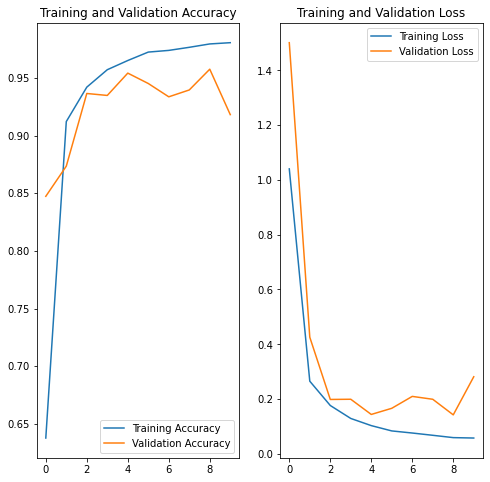

✅


In [24]:
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## Evaluation

`Test dataset`을 이용해서 모델의 성능을 평가합니다.

실습삼아 `checkpoint callback` 함수가 저장한 `weight`를 다시 불러와서 테스트 준비를 해보겠습니다.

In [26]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [27]:
#Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하겠습니다.
results = model_wav.evaluate(test_dataset)
print("✅")


47/47 [==============================] - 22s 470ms/step - loss: 0.1414 - accuracy: 0.9578
✅


In [28]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.141
accuracy value: 95.7833%
✅


## Model Test
Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해 봅시다.

In [30]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


label :  down


In [31]:
#위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅


# Skip-Connection model을 추가해보자


## Skip-Connection model 구현


하지만 여러분들은 이미지처리 모델을 다루면서 ResNet 등 skip-connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낼 수 있음을 배워왔을 것입니다. 그렇다면 이번 음성처리 모델에 적용해도 비슷한 개선 효과를 낼 수 있지 않을까요?

기존의 모델에 skip-connection이 추가된 모델로 변경해 학습을 진행해보겠습니다.

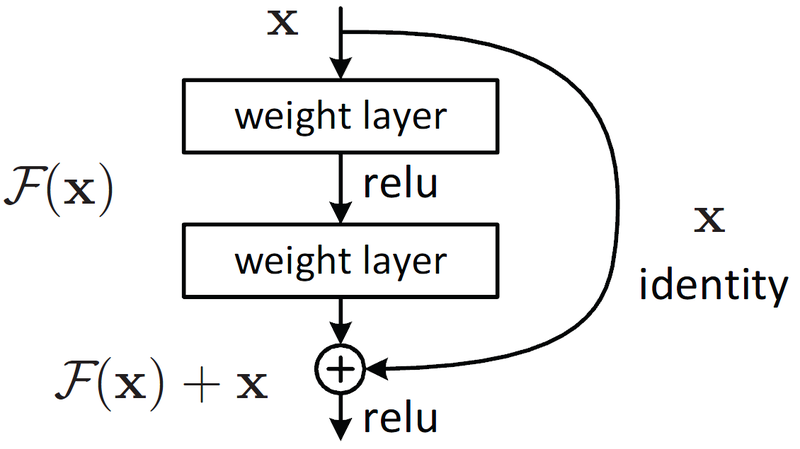


그림에서 보듯이 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨을 확인할 수 있습니다.
Concat을 이용한 방식으로 구현하면 됩니다.

`tf.concat([#layer output tensor, layer output tensor#], axis=#)`



In [32]:
input_tensor = layers.Input(shape=(130,126, 1)) #shape 2차원이기 때문에 맞춰서 바꿔줘야함 잊지말좌

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
____________________________________________________________________________________________

모델 구성만 달라졌을 뿐, 그 외 Task구성이나 데이터셋 구성, 훈련 과정은 동일합니다.

In [33]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [34]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [35]:
#30분 내외 소요
history_spec_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 1.1497 - accuracy: 0.6177
Epoch 00001: val_loss improved from inf to 0.78258, saving model to /home/ssac17/aiffel/speech_recognition/models/wav_skip
187/187 [==============================] - 98s 522ms/step - loss: 1.1497 - accuracy: 0.6177 - val_loss: 0.7826 - val_accuracy: 0.7819
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9103
Epoch 00002: val_loss improved from 0.78258 to 0.31578, saving model to /home/ssac17/aiffel/speech_recognition/models/wav_skip
187/187 [==============================] - 101s 538ms/step - loss: 0.2769 - accuracy: 0.9103 - val_loss: 0.3158 - val_accuracy: 0.8945
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9468
Epoch 00003: val_loss improved from 0.31578 to 0.17930, saving model to /home/ssac17/aiffel/speech_recognition/models/wav_skip
187/187 [==============================] - 100s 532ms/step - loss:

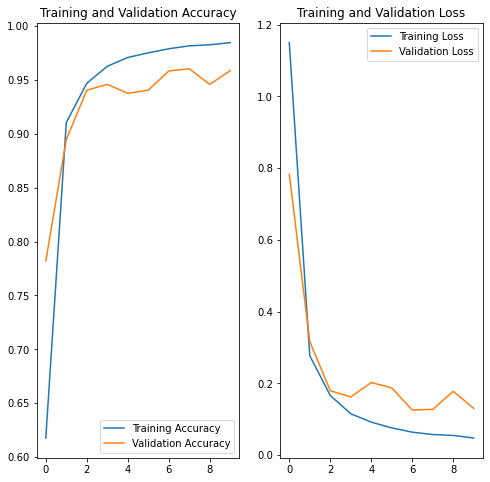

✅


In [36]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

Conv2D일반 모델과 skip-connection을 활용한 모델의 그래프의 차이를 보아하니 그래도 조금이나마  skip-connection을 활용한 모델이 loss들의 차이가 조금? 은 적어보이기도 하고,,,? 

결과는 0.1정도의 차이였지만..

In [38]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

47/47 [==============================] - 10s 216ms/step - loss: 0.1251 - accuracy: 0.9583
loss value: 0.125
accuracy value: 95.8333%
✅


In [40]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


label :  left


위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.



In [41]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: left(Correct!)
✅


### 다시 Spectrogram을 waveform으로 바꿔보기! 

`librosa.istft()`를 이용하여 다시 소리를 들어봅시당~!

In [43]:
new_data = librosa.istft(batch_xs.reshape(130, 126))
ipd.Audio(new_data, rate=8000)

## 결과 정리


**Conv2D:**

- loss value: 0.141   
- accuracy value: 95.7833%

**Skip-Connection model을 추가:**

- loss value: 0.125   
- accuracy value: 95.8333%

두 모델을 비교하기 전에도 Skip-Connection을 추가한 결과가 더 좋을 거라고 생각했다. 

그러나 아주 작은 차이가 보였다...! 사실 좀 더 큰 차이를 기대했는데 아니었다. 왜그런걸까?   
이미지 처리에서는 어느정도의 차이는 보였는데 음성 데이터라 성능의 효과가 아주 미세한 차이인걸까?   
어떤 종류 데이터인가의 차이 인것인가?   

그래프를 보아하니 그래도 train loss와 val_loss의 차이가 Skip-Connection을 추가한 그래프가 좀더 적어보이긴 했다. 그래서 보면 loss value도 10이상 좋다. 그렇지만 결과에서는 엄청난 차이는 보이지 못했다. 아니면 0.1 %의 차이도 매우 큰것일까? 


# 회고



## 어려움 : 

- 커널이 자꾸 죽었다.. 처음엔 가지고있던 40000개 이상 데이터로 잘 돌아갔는데 이리저리 시도해본다고 여러번 해서그런가...? 40000개도 Conv2D Layer를 진행할때 까진 괜찮았는데 skip connection model을 추가해서 진행하려니깐 계속 kernel dead가 몇번이고 떠서,, 재부팅도 안되길래 아, 이건 트레인 데이터 셋의 크기?가 문제라고 생각했다.

- spec_data를 ndarray로 바꾸는 과정에서 계속 커널이 죽는데 해결 방안이 있을까요? (내가 하고싶었던 질문과 똑같!)

슬랙에도 같은 문제로 고민하시는 분들이 있어 나도 같이 해결해 나갔다. 또한 슬랙에 남겨진 댓글들로 공부를 할 수 있었다!

spec = []    
for wav in speech_data["wav_vals"]:     
   spec.append(wav2spec(wav))    
spec = np.array(spec)   


- numpy ndarray 객체를 반복문에 활용하는건 굉장히 비효율적이라고 한다. 

- ndarray 자체를 for문 iterate 객체로 쓰지 마시고 인덱스로 접근해서 대입해보자. 

- spec data를 리스트에 안넣고 ndarray를 shape, dtype 명시해줘서 만들어 넣어줬고 wav2spec 함수자체를 대입연산에서 바로 사용하셨다고 함.

- np.abs(librosa.stft(wav, n_fft=fft_size)) 이거 자체를 대입연산에 넣어서 나도 함수를 다시 만들었다.

- 혜림 퍼실님 답변 : 수치연산을 할때는 리스트보다 배열이 빠르지만, 뭔가를 붙이고 뺄떄는 리스트만큼 빠른게 없습니닷
  그래서 위 예제와 같이 wav를 붙이는 작업은 리스트로 빠르게 붙이고 배열변환로 변환하는 작업이 빠르죠.


2. train data set의 크기 문제 : 30000개로 하니 잘 진행 되었다. 

- 항상 노드를 진행할때 변수이름을 설정하는게 매우 중요하다고 느꼇는데 이번에도 wav에서 spec으로 변환시켰는데 제대로 꼼꼼하게 하지않아 중간중간,,, wav의 흔적이 남아있다..! 다음번엔 제대로 확인해서 진행해야겠다.

- cpu? vs gpu

이 노드를 진행하는데 슬랙에도 많이 올라왔던 문제인 gpu가 돌아가고 있는지! 
처음에 진행했을 때는 절로 gpu가 98%로 잘 진행되고 있음을 확인하였는데 커널이 멈추고 재부팅을 했을때에는 cpu로 돌아가면서 45분? 걸린다고 나왔을때 식겁했다. nvidia-smi로 들어가 확인을 해보면서 작업을 진행해야 한다는 것도 알수 있었다. 그리고 여러번 커널이 죽고 실행이 잘 안되면서 gpu init이라는 초기화 방법을 알 수 있어서 이 방법도 사용해보았다. 

- 앞으로도 진행속도가 현저하게 느리다면 gpu가 사용되고 있는지를 꼭 확인해보자~!




## 궁금증: 
- 만약에, 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까요?

: 더 좋은 성능을 가질 것 같다. 하지만 변환 시킬때의 어떤 데이터 유실..? 이런 문제도 있을까? 


- 훈련을 시킬때 batch_size를 16,32,128 로 나눠서 진행했을 때 훈련 속도가 차이가 있었었다. Conv1D로 진행해보았을때는 128로 조절했을때 가장 빠른 속도를 나타내었다. 그래서 Conv2D로 진행할때에도 128로 조절해서 진행해보았는데 오히려 더 오래걸린다고 느꼈다. 다른이유가 있는 걸까..? gpu 초기화를 하지 않고 계속 누적해서 느려진걸까?

- batch_size를 32로, epoch를 15~20으로 조절 했으면 더 좋은 결과가 나왔을까,,?



##  참고 및 부족한 이론내용 알고가기 

[ TensorFlow Lite 튜토리얼 2 부 : 음성 인식 모델 교육](https://www.digikey.com/en/maker/projects/tensorflow-lite-tutorial-part-2-speech-recognition-model-training/d8d04a2b60a442cf8c3fa5c0dd2a292b)

[Speech Recognition Model Training](https://www.youtube.com/watch?v=yv_WVwr6OkI&feature=emb_logo)

[위자료 한글 번역~!](https://blog.naver.com/damtaja/221999528752)

https://www.geeksforgeeks.org/keras-conv2d-class/

[Sound Classification using Deep Learning](https://mikesmales.medium.com/sound-classification-using-deep-learning-8bc2aa1990b7)

[Urban Sound Classification, part 1 audio classification](https://blog.naver.com/phj8498/221271057078)


[STFT understanding using librosa](https://stackoverflow.com/questions/57058875/stft-understanding-using-librosa)

## Conv1D VS Conv2D

- Conv1D





- Conv2D

gpu 초기화 

In [ ]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
%config Completer.use_jedi = False